In [1]:
import torch
import flwr as fl
import random
import numpy as np
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, Normalize, ToTensor
from client import get_client_generator, weighted_average_accuracy
from dataset import partition_dataset
from flwr.server.strategy import FedAvg
from flwr.simulation.backend.multiprocessing import MultiProcessingBackend
from flwr.simulation.backend.deterministic import SingleThreadedBackend
transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
train_dataset = MNIST("./mnist", train=True, download=True, transform=transform)
val_dataset = MNIST("./mnist", train=False, transform=transform)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

def seed_everything(seed):
    import random
    import numpy as np
    import torch
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def complete_run(seed=None, mode="ray"):
    if seed is not None:
        seed_everything(seed)

    num_clients = 6
    train_datasets = partition_dataset(train_dataset, 100)
    val_datasets = partition_dataset(val_dataset, 100)
    train_dataloaders = [torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True) for dataset in train_datasets]
    val_dataloaders = [torch.utils.data.DataLoader(dataset, batch_size=16) for dataset in val_datasets]
    client_fn = get_client_generator(train_dataloaders, val_dataloaders)
    client_config = {
        "lr": 0.05,
        "epochs": 1,
    }
    strategy = FedAvg(
        min_fit_clients=2,
        min_evaluate_clients=2,
        min_available_clients=2,
        fraction_fit=0.5,
        fraction_evaluate=0.5,
        on_fit_config_fn=lambda _: client_config,
        on_evaluate_config_fn=lambda _: client_config,
        evaluate_metrics_aggregation_fn=weighted_average_accuracy,
    )
    if mode == "ray":
        backend = None
    elif mode == "multiprocessing":
        backend = MultiProcessingBackend()
    elif mode == "single_threaded":
        backend = SingleThreadedBackend()
    else:
        raise ValueError("Unknown mode")
    hist = fl.simulation.start_simulation(
        client_fn=client_fn,
        seed_fn=seed_everything if seed is not None else None,
        seed=seed,
        num_clients=num_clients,
        config=fl.server.ServerConfig(num_rounds=5),
        strategy=strategy,
        backend=backend
    )

    return hist

/home/fredrik/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


./mnist/MNIST/raw/train-labels-idx1-ubyte
./mnist/MNIST/raw/t10k-labels-idx1-ubyte


In [2]:
import matplotlib.pyplot as plt

def plot_runs(runs):
    fig_loss, axs_loss = plt.subplots(1, len(runs), sharey=True)
    fig_acc, axs_acc = plt.subplots(1, len(runs), sharey=True)
    for i, run in enumerate(runs):
        axs_loss[i].plot([x[1] for x in run.losses_distributed])
        axs_acc[i].plot([x[1] for x in run.metrics_distributed["accuracy"]])
        if i>0:
            plt.setp(axs_loss[i].get_yticklabels(), visible=False)
            plt.setp(axs_acc[i].get_yticklabels(), visible=False)
    fig_loss.suptitle("Loss")
    fig_loss.set_size_inches(9,3)
    fig_loss.show()
    fig_acc.suptitle("Accuracy")
    fig_acc.set_size_inches(9,3)
    fig_acc.show()

INFO flwr 2023-03-14 05:07:23,168 | app.py:199 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-03-14 05:07:24,954	INFO worker.py:1553 -- Started a local Ray instance.
INFO flwr 2023-03-14 05:07:25,680 | ray_backend.py:54 | Flower VCE: Ray initialized with resources: {'node:172.18.111.149': 1.0, 'memory': 4925590734.0, 'CPU': 12.0, 'object_store_memory': 2462795366.0}
INFO flwr 2023-03-14 05:07:26,065 | server.py:100 | Initializing global parameters
INFO flwr 2023-03-14 05:07:26,066 | server.py:291 | Requesting initial parameters from one random client
INFO flwr 2023-03-14 05:07:27,684 | server.py:295 | Received initial parameters from one random client
INFO flwr 2023-03-14 05:07:27,685 | server.py:102 | Evaluating initial parameters
INFO flwr 2023-03-14 05:07:27,686 | server.py:115 | FL starting
DEBUG flwr 2023-03-14 05:07:27,686 | server.py:232 | fit_round 1: strategy sampled 3 clients (out of 6)
DEBUG flwr 2023-03-14 05:07:29,661 | server.py:

History (loss, distributed):
	round 1: 1.6539652792612711
	round 2: 0.8846964732805888
	round 3: 0.6298033734162648
	round 4: 0.5428262354930242
	round 5: 0.4881055667002996
History (metrics, distributed):
{'accuracy': [(1, 0.6266666666666667), (2, 0.8133333333333334), (3, 0.8133333333333334), (4, 0.8266666666666667), (5, 0.84)]}
History (loss, distributed):
	round 1: 1.572940443356832
	round 2: 0.9681116445859274
	round 3: 0.6659804677963257
	round 4: 0.5790717881917954
	round 5: 0.551196258366108
History (metrics, distributed):
{'accuracy': [(1, 0.67), (2, 0.7366666666666667), (3, 0.8066666666666666), (4, 0.8266666666666667), (5, 0.84)]}
History (loss, distributed):
	round 1: 1.7487806955973306
	round 2: 0.985311807791392
	round 3: 0.690141389966011
	round 4: 0.5786528825759888
	round 5: 0.5263582556446393
History (metrics, distributed):
{'accuracy': [(1, 0.7433333333333333), (2, 0.7833333333333333), (3, 0.82), (4, 0.8166666666666667), (5, 0.83)]}


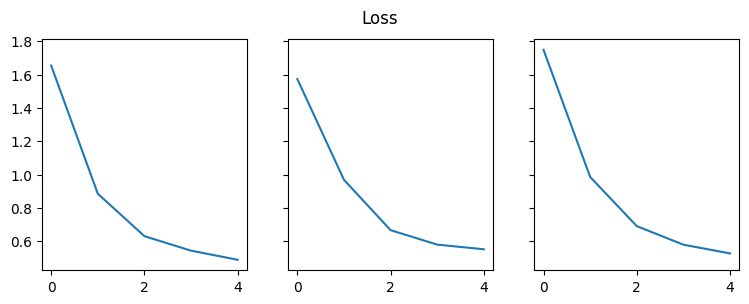

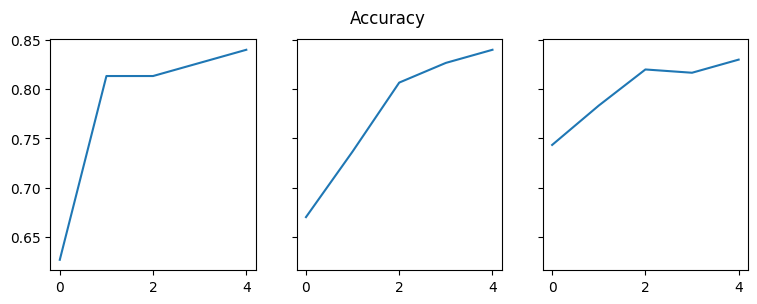

In [3]:
# Failed determinism
seed_everything(0)
run1 = complete_run(None,"ray")
seed_everything(0)
run2 = complete_run(None,"ray")
seed_everything(0)
run3 = complete_run(None,"ray")
print(run1)
print(run2)
print(run3)
plot_runs([run1,run2,run3])

INFO flwr 2023-03-14 05:08:14,555 | app.py:199 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-03-14 05:08:16,390	INFO worker.py:1553 -- Started a local Ray instance.
INFO flwr 2023-03-14 05:08:17,575 | ray_backend.py:54 | Flower VCE: Ray initialized with resources: {'CPU': 12.0, 'node:172.18.111.149': 1.0, 'memory': 4894993614.0, 'object_store_memory': 2447496806.0}
INFO flwr 2023-03-14 05:08:17,923 | server.py:100 | Initializing global parameters
INFO flwr 2023-03-14 05:08:17,925 | server.py:291 | Requesting initial parameters from one random client
INFO flwr 2023-03-14 05:08:20,073 | server.py:295 | Received initial parameters from one random client
INFO flwr 2023-03-14 05:08:20,074 | server.py:102 | Evaluating initial parameters
INFO flwr 2023-03-14 05:08:20,075 | server.py:115 | FL starting
DEBUG flwr 2023-03-14 05:08:20,076 | server.py:232 | fit_round 1: strategy sampled 3 clients (out of 6)
DEBUG flwr 2023-03-14 05:08:21,991 | server.py:

History (loss, distributed):
	round 1: 1.630920287768046
	round 2: 0.8954501064618429
	round 3: 0.6650936502218247
	round 4: 0.4962228786945343
	round 5: 0.5074827121694883
History (metrics, distributed):
{'accuracy': [(1, 0.7166666666666667), (2, 0.7533333333333333), (3, 0.8066666666666666), (4, 0.8666666666666667), (5, 0.85)]}
History (loss, distributed):
	round 1: 1.630920287768046
	round 2: 0.8954501064618429
	round 3: 0.6650936502218247
	round 4: 0.4962228786945343
	round 5: 0.5074827121694883
History (metrics, distributed):
{'accuracy': [(1, 0.7166666666666667), (2, 0.7533333333333333), (3, 0.8066666666666666), (4, 0.8666666666666667), (5, 0.85)]}
History (loss, distributed):
	round 1: 1.630920287768046
	round 2: 0.8954501064618429
	round 3: 0.6650936502218247
	round 4: 0.4962228786945343
	round 5: 0.5074827121694883
History (metrics, distributed):
{'accuracy': [(1, 0.7166666666666667), (2, 0.7533333333333333), (3, 0.8066666666666666), (4, 0.8666666666666667), (5, 0.85)]}


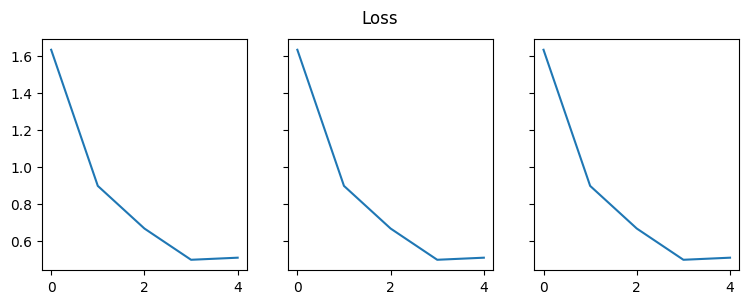

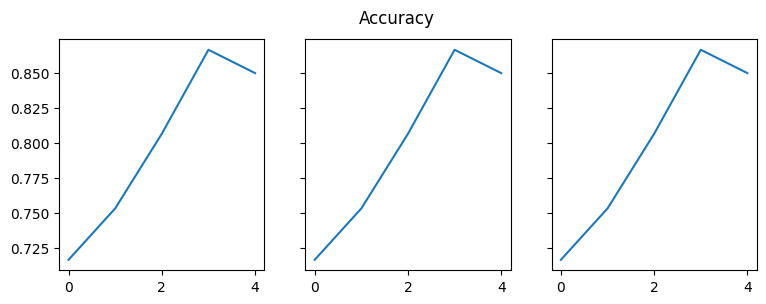

In [4]:
# Successful determinism
run1 = complete_run(0,"ray")
run2 = complete_run(0,"ray")
run3 = complete_run(0,"ray")
print(run1)
print(run2)
print(run3)
plot_runs([run1,run2,run3])